# Reprise du projet 5 avec le jeux MNIST original
## Imports et fonctions

In [1]:
import numpy as np

import random

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier

import h5py

import time

import matplotlib.pyplot as plt 

from joblib import dump, load

In [2]:
def erreur_prediction(valeurs_predites= None, valeurs_reelle= None):
    """
    Vérifie que les valeurs prédites sont les mêmes que les valeurs réelles.
    
    paramètres en entrée:
    valeurs_predites
    valeurs_reelle
    
    Paramètres de sortie:
    erreur: nombre d'erreur de prédiction
    precision: 100*(1-erreur/(longueur des tableaux)
    liste_erreur: Liste de toutes les erreurs détecté sous forme de dictionnaire 
        clé valeur réelle: valeur prédite
    """
    
    assert len(valeurs_predites) == len(valeurs_reelle), "Erreur de dimension: la dimension des tableaux "+\
        f"doit être identique. {len(valeurs_predites)} # de {len(valeurs_reelle)}"

    erreur= 0
    d= {}
    longueur= len(valeurs_reelle)
    for i in range(longueur):
        if valeurs_reelle[i]!= valeurs_predites[i]:
            if valeurs_reelle[i] not in d.keys():
                d[valeurs_reelle[i]]= [valeurs_predites[i]]
            else:
                d[valeurs_reelle[i]].append(valeurs_predites[i])
            erreur+= 1
        
    return erreur, 100*(1-erreur/longueur), d

## Reprise partielle du brief

In [3]:
# Importation des données depuis scikit learn datasets
digits = load_digits()

# Les images sont organisées en matrice de 8x8
X = digits.images
# Labels des images (chiffre de 0 à 9)
Y = digits.target
# Les images sont "applaties" et transformées en un tableau de 64 éléments 
Xdata= digits.data

print(f"X Shape: {X.shape}, Xdata Shape: {Xdata.shape}, Y shape: {Y.shape}, "+\
      f"digits.target_name: {digits.target_names}\n")

X Shape: (1797, 8, 8), Xdata Shape: (1797, 64), Y shape: (1797,), digits.target_name: [0 1 2 3 4 5 6 7 8 9]



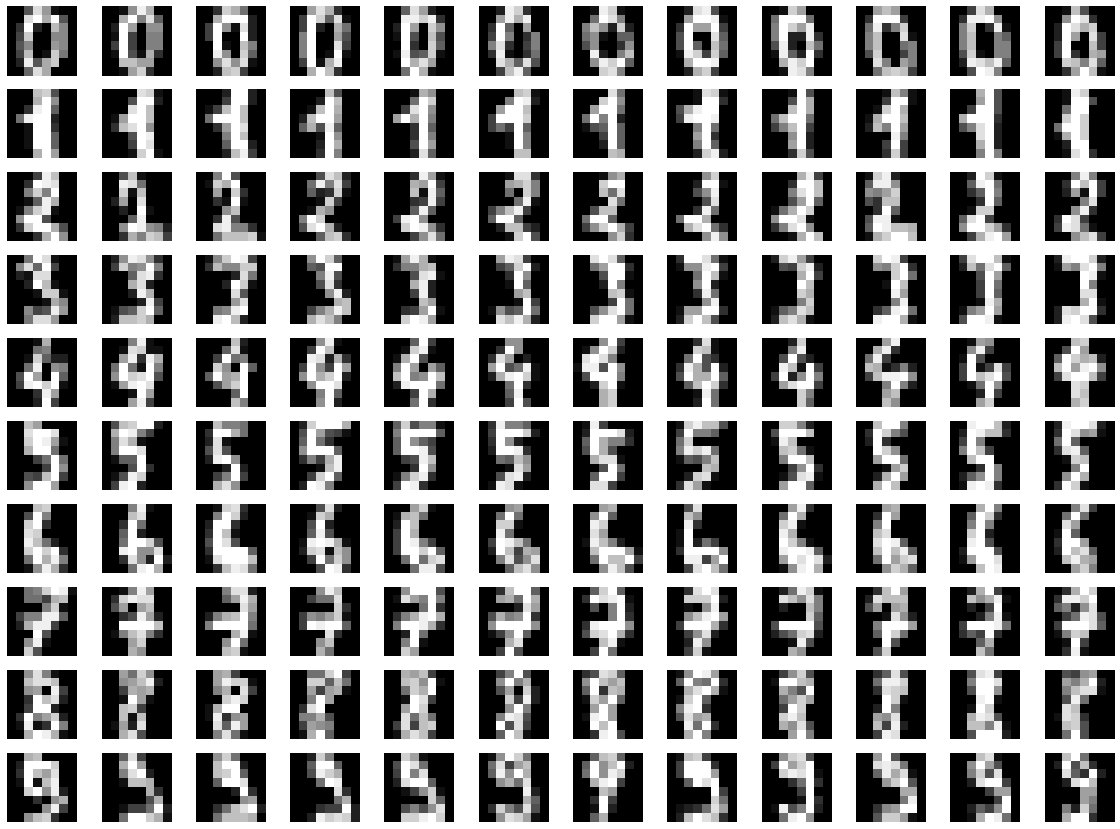

In [4]:
# Préparation de l'affichage
n_digits = np.unique(Y) # = 0,1,2,...9
M =12

fig, axs = plt.subplots(len(n_digits), M, figsize=(20, 15))

# Afficher M exemples de tout les digits (de 0 à 9)
for i, d in enumerate(n_digits):
    x= X[Y == d]
    for j in range(M):
        num= random.randint(0,x.shape[0]-1)        
        axs[i,j].imshow(X[Y == d][j], cmap="gray")
        axs[i,j].axis('off')

In [5]:
# On split le jeux de données
X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Y, test_size=0.2, random_state= 511)

# On construit et on 'fit' le modèle
log_regr = LogisticRegression(solver='liblinear')
log_regr.fit(X_train, Y_train)

# on teste sur les données de.... test :)
prediction = log_regr.predict(X_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test)
print(f"{err} erreurs sur {len(X_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

19 erreurs sur 360 images soit une précision de 94.72 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [1, 1, 1, 3, 1], 3: [5, 8], 9: [8, 3, 4, 8], 5: [9, 9, 9, 9], 4: [7, 6], 1: [6, 8]}


In [6]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("\n",classification_report(Y_test,prediction, target_names=target_names))



                 precision    recall  f1-score   support

détection de 0       1.00      1.00      1.00        31
détection de 1       0.89      0.94      0.91        33
détection de 2       1.00      1.00      1.00        35
détection de 3       0.94      0.94      0.94        36
détection de 4       0.97      0.95      0.96        41
détection de 5       0.98      0.91      0.94        45
détection de 6       0.95      1.00      0.97        35
détection de 7       0.97      1.00      0.98        31
détection de 8       0.90      0.88      0.89        40
détection de 9       0.88      0.88      0.88        33

      accuracy                           0.95       360
     macro avg       0.95      0.95      0.95       360
  weighted avg       0.95      0.95      0.95       360



# Reprise du brief 5 avec MNIST

## Importation et visualisation des données du dataset MNIST

In [7]:
# Importation du jeux d'entraînement
f = h5py.File("train.hdf5", 'r')
train_x, train_y = f['image'][...], f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("test.hdf5", 'r')
test_x, test_y = f['image'][...], f['label'][...]
f.close()

etiquette= np.unique(test_y)
print(f"Entrainement: X Shape: {train_x.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {test_x.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28), Y shape: (60000,)
Test: X Shape: (10000, 28, 28), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


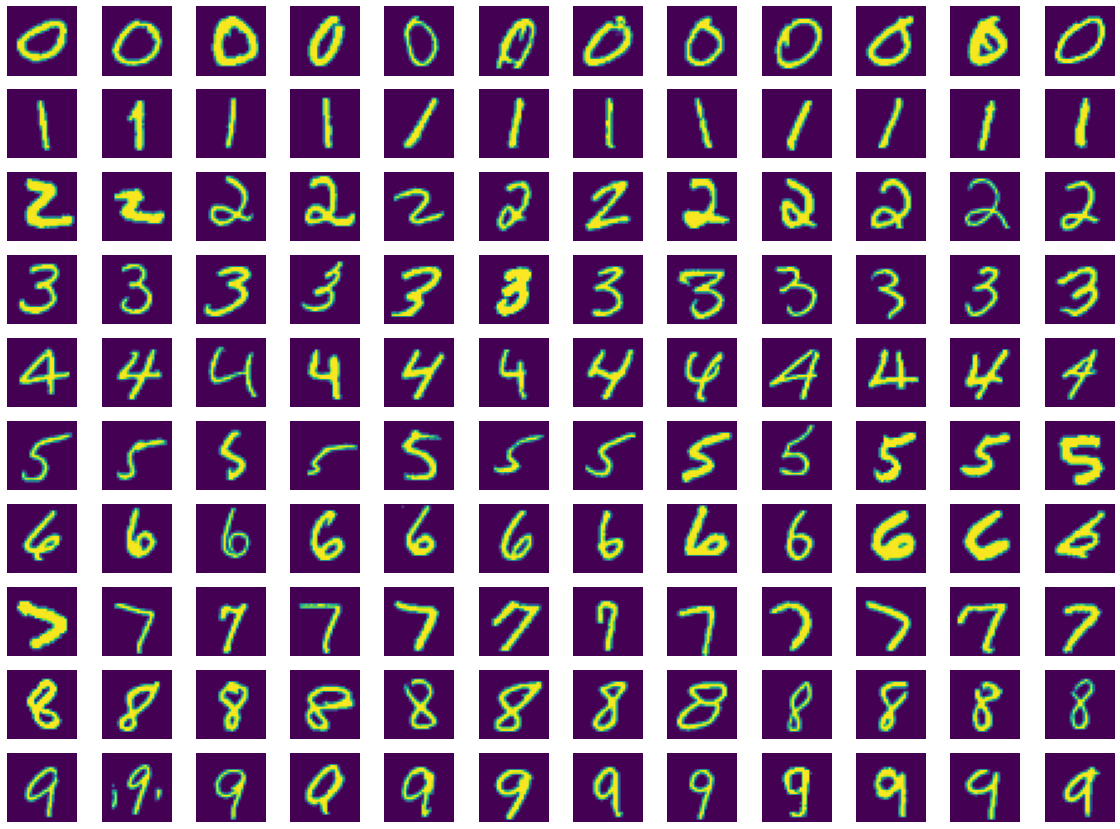

In [8]:
# Préparation de l'affichage
M= 12
fig, axs = plt.subplots(len(etiquette), M, figsize=(20, 15))

# Afficher M exemples de tout les digits (de 0 à 9)
for i, d in enumerate(etiquette):
    x= train_x[train_y == d]
    for j in range(M):
        num= random.randint(0, x.shape[0]-1)        
        axs[i,j].imshow(x[num])
        axs[i,j].axis('off')


## On test en se plaçant dans les mêmes conditions que pour le brief 5

In [9]:
# On récupère les données. On ne prendra qu'une partie des données situé dans le
#  jeux de train. On en profite pour "applatir" les images
data= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])

# On réduit le jeux de données original
data_red, _, Y_red, _=  train_test_split(data, train_y, train_size=0.1, random_state= 65)

# On split le jeux de données
X_train_red, X_test_red,  Y_train_red, Y_test_red = train_test_split(data_red, Y_red, train_size=0.8, 
                                                               random_state= 65)

print(f"Entrainement: X Shape: {X_train_red.shape}, Y shape: {Y_train_red.shape}\n"+\
      f"Test: X Shape: {X_test_red.shape}, Y shape: {Y_test_red.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (4800, 784), Y shape: (4800,)
Test: X Shape: (1200, 784), Y shape: (1200,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [10]:
# Le jeux de donnée est-il équilibré ?
d= {}
for i in etiquette:
    l= len(X_train_red[Y_train_red== i])
    d[i]= l
    print(f"Le chiffre {i} est représenté {l} fois", end= " - ")
mini, maxi= min(d, key= d.get), max(d, key= d.get)
print(f"\nLe chiffre le moins représenté est {mini} représenté {d[mini]} fois.")
print(f"Le chiffre le plus représenté est {maxi} représenté {d[maxi]} fois.")

Le chiffre 0 est représenté 483 fois - Le chiffre 1 est représenté 546 fois - Le chiffre 2 est représenté 472 fois - Le chiffre 3 est représenté 483 fois - Le chiffre 4 est représenté 473 fois - Le chiffre 5 est représenté 431 fois - Le chiffre 6 est représenté 482 fois - Le chiffre 7 est représenté 480 fois - Le chiffre 8 est représenté 487 fois - Le chiffre 9 est représenté 463 fois - 
Le chiffre le moins représenté est 5 représenté 431 fois.
Le chiffre le plus représenté est 1 représenté 546 fois.


In [11]:
deb= time.time()
# On construit et on 'fit' le modèle
model_reglog = LogisticRegression(solver='liblinear')
model_reglog.fit(X_train_red, Y_train_red)
fin= time.time()
print(f"temps d'exécution: {fin-deb:.2f} s")

temps d'exécution: 46.99 s


/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## On teste l'algorithme

In [12]:
# on teste sur les données de.... test :)
prediction = model_reglog.predict(X_test_red)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

225 erreurs sur 1200 images soit une précision de 81.25 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [3, 3, 5, 5, 5, 4, 5, 2, 3, 0, 3, 9, 1, 2, 9, 1, 2, 4, 9, 3, 3, 2, 9], 2: [3, 7, 9, 0, 7, 6, 8, 0, 9, 3, 7, 1, 3, 6, 1, 1, 5, 0, 0, 8, 5, 5, 8, 5, 8, 3, 6, 3, 8, 8, 7, 8, 3, 9, 8, 8], 5: [3, 3, 3, 9, 8, 8, 9, 3, 9, 6, 8, 4, 3, 9, 3, 3, 3, 3, 4, 3, 8, 2, 6, 6, 3, 9, 3, 3, 8, 8, 9, 9, 8, 3, 8, 6, 8], 9: [8, 8, 7, 4, 1, 8, 4, 4, 8, 4, 4, 8, 8, 2, 3, 8, 7, 8, 8, 4, 2, 7, 8, 8, 7], 3: [7, 5, 9, 8, 8, 8, 8, 2, 8, 8, 6, 2, 0, 9, 8, 0, 8, 8, 8, 5, 8, 7, 8, 8, 8, 5, 5, 8, 8, 5, 8, 8, 8, 8, 4, 8, 8, 8], 4: [9, 8, 7, 8, 2, 9, 0, 8, 3, 8, 2, 9, 2, 7, 8, 8, 9, 3, 9, 6, 9, 9, 7, 5, 0], 7: [1, 4, 4, 9, 3, 8, 3, 3, 1, 3, 9, 2, 5, 9, 9, 9, 8, 9, 9, 2, 5], 6: [8, 0, 5, 3, 8, 5, 8], 0: [6, 5, 4, 2, 6, 9, 8], 1: [3, 8, 3, 9, 3, 2]}


In [13]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("Le score obtenu est de {} % de bonne prédictions".
      format(round(model_reglog.score(X_test_red, Y_test_red)*100,2)))
print("\n",classification_report(Y_test_red,prediction, target_names= target_names)) 

Le score obtenu est de 81.25 % de bonne prédictions

                 precision    recall  f1-score   support

détection de 0       0.92      0.94      0.93       126
détection de 1       0.93      0.95      0.94       117
détection de 2       0.86      0.74      0.80       137
détection de 3       0.67      0.66      0.66       112
détection de 4       0.88      0.80      0.83       123
détection de 5       0.78      0.64      0.70       103
détection de 6       0.92      0.95      0.93       135
détection de 7       0.88      0.82      0.85       119
détection de 8       0.57      0.79      0.66       110
détection de 9       0.74      0.79      0.77       118

      accuracy                           0.81      1200
     macro avg       0.82      0.81      0.81      1200
  weighted avg       0.82      0.81      0.81      1200



## Normalisation des données et test d'un nouveau solver

In [14]:
# On récupère les données. On ne prendra qu'une partie des données situé dans le
#  jeux de train. On en profite pour "applatir" les images
data= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])

# On réduit le jeux de données original
data_red, _, Y_red, _=  train_test_split(data, train_y, train_size=0.1, random_state= 65)

# Standardisation
scaler=StandardScaler()
datastd= scaler.fit_transform(data_red)

# On split le jeux de données
X_train_red, X_test_red,  Y_train_red, Y_test_red = train_test_split(datastd, Y_red, train_size=0.8, 
                                                               random_state= 65)

print(f"Entrainement: X Shape: {X_train_red.shape}, Y shape: {Y_train_red.shape}\n"+\
      f"Test: X Shape: {X_test_red.shape}, Y shape: {Y_test_red.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (4800, 784), Y shape: (4800,)
Test: X Shape: (1200, 784), Y shape: (1200,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [15]:
deb= time.time()
# On construit et on 'fit' le modèle
model_reglog = LogisticRegression(solver='lbfgs', class_weight= "balanced", max_iter= 2000)
model_reglog.fit(X_train_red, Y_train_red)
fin= time.time()
print(f"temps d'exécution: {fin-deb:.2f} s")

temps d'exécution: 14.49 s


In [16]:
# on teste sur les données de.... test :)
prediction = model_reglog.predict(X_test_red)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

126 erreurs sur 1200 images soit une précision de 89.50 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [3, 5, 5, 3, 6, 2, 5, 2, 1, 3, 1, 3, 2, 1, 9], 2: [3, 8, 3, 7, 6, 1, 3, 4, 4, 3, 1, 0, 3, 1, 0, 7, 6, 7, 4, 7, 3, 6, 0, 9, 8, 3], 5: [3, 3, 8, 0, 3, 9, 4, 3, 1, 0, 9, 3, 6, 8, 4, 3, 9, 8, 9, 8, 0, 8, 8], 3: [5, 9, 8, 2, 8, 2, 0, 0, 5, 5, 7, 2, 8, 8], 9: [4, 1, 3, 4, 3, 4, 4, 2, 4, 3, 8, 8, 4, 7], 6: [8, 5, 0, 8, 5], 4: [3, 8, 2, 9, 8, 1, 9, 2, 8, 0], 1: [2, 3, 2], 0: [6, 5, 4, 6, 6, 7], 7: [4, 3, 9, 4, 9, 9, 1, 5, 9, 9]}


In [17]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print(f"Le score obtenu est de {model_reglog.score(X_test_red, Y_test_red)*100:.2f}")
print("\n",classification_report(Y_test_red,prediction, target_names= target_names)) 


Le score obtenu est de 89.50

                 precision    recall  f1-score   support

détection de 0       0.92      0.95      0.94       126
détection de 1       0.92      0.97      0.95       117
détection de 2       0.91      0.81      0.86       137
détection de 3       0.81      0.88      0.84       112
détection de 4       0.89      0.92      0.90       123
détection de 5       0.89      0.78      0.83       103
détection de 6       0.94      0.96      0.95       135
détection de 7       0.94      0.92      0.93       119
détection de 8       0.83      0.86      0.85       110
détection de 9       0.88      0.88      0.88       118

      accuracy                           0.90      1200
     macro avg       0.89      0.89      0.89      1200
  weighted avg       0.90      0.90      0.89      1200



## Gridsearch CV pour déterminer la meilleure standardisation et le meilleur solver pour la régression logistique

In [18]:
# On récupère les données. On ne prendra qu'une partie des données situé dans le
#  jeux de train. On en profite pour "applatir" les images
data= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])

# On réduit le jeux de données original
data_red, _, Y_red, _=  train_test_split(data, train_y, train_size=0.1, random_state= 65)

# On split le jeux de données
X_train_red, X_test_red,  Y_train_red, Y_test_red = train_test_split(data_red, Y_red, train_size=0.8, 
                                                               random_state= 65)

print(f"Entrainement: X Shape: {X_train_red.shape}, Y shape: {Y_train_red.shape}\n"+\
      f"Test: X Shape: {X_test_red.shape}, Y shape: {Y_test_red.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (4800, 784), Y shape: (4800,)
Test: X Shape: (1200, 784), Y shape: (1200,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [19]:
# On réalise un pipe avec 2 actions: un scaler et un algorithme
pipe = Pipeline(steps= [('scaler', StandardScaler()), ('algo', LogisticRegression())])

# On testera 3 standardisations et pour la régression logistique on testera tout les solvers
param_grid = {'pipeline__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
              'pipeline__algo__solver': ["sag", "newton-cg", "lbfgs", "saga"],
              'pipeline__algo__class_weight': ["balanced"],
              'pipeline__algo__max_iter': [2000]}
# instantiate and run as before:

model= make_pipeline(pipe)

grid = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('scaler',
                                                         StandardScaler()),
                                                        ('algo',
                                                         LogisticRegression())]))]),
             n_jobs=-1,
             param_grid={'pipeline__algo__class_weight': ['balanced'],
                         'pipeline__algo__max_iter': [2000],
                         'pipeline__algo__solver': ['sag', 'newton-cg', 'lbfgs',
                                                    'saga'],
                         'pipeline__scaler': [StandardScaler(), MinMaxScaler(),
                                              RobustScaler()]})

In [20]:
deb= time.time()

grid.fit(X_train_red, Y_train_red)

fin= time.time()
print(f"temps d'exécution: {fin-deb:.2f} s")

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_log

temps d'exécution: 8379.82 s


In [28]:
grid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('algo',
                                  LogisticRegression(class_weight='balanced',
                                                     max_iter=2000,
                                                     solver='newton-cg'))]))])

In [29]:
print(f"Précision obtenu: {100*grid.best_score_:.2f} %")

Précision obtenu: 88.40 %


In [31]:
# on teste sur les données de.... test :)
prediction = grid.best_estimator_.predict(X_test_red)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

111 erreurs sur 1200 images soit une précision de 90.75 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [3, 5, 5, 5, 3, 2, 5, 1, 5, 3, 1, 3, 1, 9], 2: [7, 8, 0, 7, 1, 3, 4, 7, 3, 1, 0, 1, 7, 6, 7, 6, 7, 3, 6, 8, 8, 8, 3], 5: [3, 3, 8, 3, 9, 4, 3, 0, 9, 3, 3, 9, 8, 0, 8, 8], 7: [5, 4, 3, 9, 9, 9, 9, 2, 5, 9, 9], 3: [8, 2, 5, 2, 0, 9, 0, 5, 5, 8, 7, 2, 8, 8], 6: [8, 5, 7, 5, 5], 4: [3, 2, 9, 8, 1, 9, 9, 8, 8, 8, 0], 0: [6, 5, 4], 9: [1, 4, 4, 8, 4, 7, 3, 3, 7, 8, 4, 7], 1: [3, 3]}


In [32]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("\n",classification_report(Y_test_red,prediction, target_names= target_names)) 


                 precision    recall  f1-score   support

détection de 0       0.95      0.98      0.96       126
détection de 1       0.93      0.98      0.96       117
détection de 2       0.95      0.83      0.89       137
détection de 3       0.83      0.88      0.85       112
détection de 4       0.93      0.91      0.92       123
détection de 5       0.86      0.84      0.85       103
détection de 6       0.97      0.96      0.97       135
détection de 7       0.91      0.91      0.91       119
détection de 8       0.83      0.87      0.85       110
détection de 9       0.88      0.90      0.89       118

      accuracy                           0.91      1200
     macro avg       0.91      0.91      0.91      1200
  weighted avg       0.91      0.91      0.91      1200



## Learning curve
On fera cette étude en prenant l'intégralité du jeux de données avec le meilleur solver.

In [33]:
# On récupère les données et on en profite pour "applatir" les images
data_train= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
data_test= test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])

etiquette= np.unique(test_y)

print(f"Entrainement: X Shape: {data_train.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 784), Y shape: (60000,)
Test: X Shape: (10000, 784), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [34]:
# On choisi le meilleur solver avec une standardisation min/max
pipe_minmax_logreg= make_pipeline(MinMaxScaler(), LogisticRegression(class_weight='balanced', 
                                                                      max_iter=2000, solver='newton-cg'))

pipe_minmax_logreg.fit(data_train, train_y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    solver='newton-cg'))])

In [35]:
prediction = pipe_minmax_logreg.predict(data_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= test_y)
print(f"{err} erreurs sur {len(data_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

737 erreurs sur 10000 images soit une précision de 92.63 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{5: [6, 7, 3, 0, 8, 3, 8, 8, 3, 7, 8, 9, 3, 4, 3, 8, 3, 6, 7, 6, 3, 0, 8, 0, 3, 3, 4, 9, 8, 8, 8, 4, 8, 3, 2, 8, 7, 3, 8, 0, 3, 3, 2, 0, 7, 7, 9, 9, 4, 0, 8, 4, 8, 0, 2, 3, 3, 3, 1, 6, 8, 8, 4, 3, 8, 6, 3, 8, 6, 8, 8, 1, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 6, 4, 8, 6, 8, 3, 6, 8, 8, 8, 4, 4, 8, 8, 3, 6, 3, 3, 3, 6, 6, 0, 0, 6, 6, 3, 6], 4: [6, 6, 2, 9, 9, 9, 9, 8, 9, 1, 6, 9, 6, 9, 9, 9, 3, 7, 3, 6, 8, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 2, 9, 9, 2, 2, 9, 1, 9, 2, 6, 9, 9, 1, 6, 9, 3, 7, 0, 9, 8, 9, 8, 8, 9, 9, 9, 7, 2, 9, 8], 3: [2, 5, 5, 5, 7, 5, 2, 6, 5, 2, 5, 5, 8, 5, 9, 8, 7, 9, 8, 7, 7, 5, 7, 5, 1, 8, 5, 9, 5, 5, 6, 5, 0, 2, 7, 5, 5, 2, 2, 2, 8, 5, 2, 2, 7, 7, 7, 5, 9, 8, 5, 2, 8, 5, 8, 4, 2, 0, 9, 0, 8, 8, 5, 8, 8, 8, 8, 8, 7, 5, 8, 2, 2, 2, 2, 8, 8, 5, 8, 8, 5, 8, 2, 0, 9, 2, 8, 9, 8], 6: [2, 5, 0, 0, 0, 5, 2, 2, 1, 8, 7, 7, 5, 4, 0, 2, 1, 5, 4, 5, 1, 2, 4, 0, 3, 0, 4

In [36]:
train_size, train_score, val_score= learning_curve(pipe_minmax_logreg, data_train, train_y, 
                                          train_sizes= np.linspace(0.05,1,20), cv= 3)

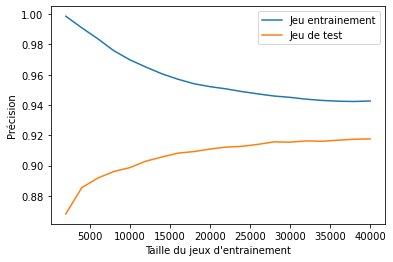

In [37]:
plt.plot(train_size, train_score.mean(axis=1), label= "Jeu entrainement")
plt.plot(train_size, val_score.mean(axis=1), label= "Jeu de test")
plt.xlabel("Taille du jeux d'entrainement")
plt.ylabel("Précision")
_= plt.legend()

In [44]:
dump(pipe_minmax_logreg, 'minmax_logreg_newton_balanced.modele') 

['minmax_logreg_newton_balanced.modele']

## Recherche de nouveau algo - KNN classifier

In [39]:
# On récupère les données et on en profite pour "applatir" les images
data_train= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
data_test= test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])

etiquette= np.unique(test_y)

print(f"Entrainement: X Shape: {data_train.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 784), Y shape: (60000,)
Test: X Shape: (10000, 784), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [40]:
# On choisi les meilleurs paramètres en gardant la standardisation min/max
pipe_minmax_knn= make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors= 6, weights= "distance",
                                                                    algorithm='ball_tree', p= 3))

pipe_minmax_knn.fit(data_train, train_y)
prediction = pipe_minmax_knn.predict(data_test)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=6, p=3,
                                      weights='distance'))])

In [42]:
err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= test_y)
print(f"{err} erreurs sur {len(data_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

263 erreurs sur 10000 images soit une précision de 97.37 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{4: [0, 9, 6, 1, 9, 9, 9, 6, 9, 1, 9, 8, 9, 9, 9, 6, 6, 9, 9, 9, 1, 7, 1, 9, 7, 1, 1, 9, 9], 3: [5, 7, 7, 5, 5, 9, 7, 4, 5, 2, 5, 5, 5, 7, 7, 5, 7, 5, 5, 8, 2, 7, 6, 8, 9, 5, 9, 5, 9, 5, 5, 9, 8], 9: [8, 7, 8, 4, 0, 3, 5, 3, 4, 2, 6, 1, 4, 7, 0, 7, 1, 7, 4, 1, 1, 3, 3, 2, 7, 7, 2, 4, 1, 4, 5, 3, 5, 0, 0, 0, 7, 7, 4], 2: [7, 8, 7, 6, 7, 7, 0, 7, 0, 7, 0, 7, 1, 0, 7, 6, 1, 1, 3, 7, 7, 3, 7, 7, 7, 0, 7, 0, 1, 7, 0, 0, 0, 8, 7, 8, 0], 6: [4, 0, 5, 0, 1, 4, 5, 1, 0, 4, 0, 1, 0], 7: [4, 1, 4, 2, 1, 1, 1, 9, 9, 1, 1, 1, 1, 9, 1, 1, 1, 1, 9, 9, 9, 9, 1, 1, 1, 9, 9, 9, 9, 1, 1, 2, 2, 2], 8: [0, 1, 3, 3, 3, 9, 4, 3, 3, 7, 4, 5, 3, 2, 4, 2, 3, 3, 6, 6, 3, 5, 0, 0, 5, 2, 7, 9, 3, 7, 6, 0, 6, 2, 4, 9, 9, 7, 9, 4, 5, 5], 5: [9, 4, 3, 6, 9, 7, 3, 6, 8, 8, 3, 9, 9, 0, 8, 4, 6, 3, 6, 9, 6, 6, 0, 6, 0, 6], 1: [2, 2, 6], 0: [6, 2, 7, 5, 6, 1, 6]}


In [43]:
# Sauvegarde du modèle
dump(pipe_minmax_knn, 'minmax_knn6_distance_balltreep3.modele') 

['minmax_knn6_distance_balltreep3.modele']

## Test d'un CNN

In [4]:
import tensorflow as tf
#from tensorflow import keras
#from keras.datasets import mnist

import h5py

import numpy as np

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

In [2]:
# Importation du jeux d'entraînement
f = h5py.File("train.hdf5", 'r')
train_x, train_y = f['image'][...], f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("test.hdf5", 'r')
test_x, test_y = f['image'][...], f['label'][...]
f.close()

In [12]:
# On récupère les données et on les met en forme pour qu'elles soient compatible avec le CNN.
# la dimension des données de test et de train sont de type:
#  (shape[0],shape[1], shape[2]), il sera nécessaire d'y ajouter une dimension supplémentaire
data_train_pour_cnn= train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
data_test_pour_cnn= test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

etiquette= np.unique(test_y)

# convert class vectors to binary class matrices
train_y_conv = keras.utils.to_categorical(train_y, len(etiquette))
test_y_conv = keras.utils.to_categorical(test_y, len(etiquette))


print(f"Entrainement: X Shape: {data_train_pour_cnn.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test_pour_cnn.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28, 1), Y shape: (60000,)
Test: X Shape: (10000, 28, 28, 1), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [13]:
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [11]:
input_shape

(28, 28, 1)

In [21]:
batch_size = 128
num_classes = 10
epochs = 250

input_shape= (train_x.shape[1], train_x.shape[2], 1)
nb_classe= len(etiquette)
"""
model= tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape= input_shape ),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
])
"""

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape= input_shape ))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classe, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])


In [22]:
hist = model.fit(data_train_pour_cnn, train_y_conv, batch_size=batch_size, epochs=epochs, 
                 verbose=1,validation_data=(data_test_pour_cnn, test_y_conv))

#print("The model has successfully trained")
model.save(f'mnist_{epochs}.h5')
#print("Saving the model as mnist.h5")
print("sauvegarde du modèle.")

Epoch 1/250
469/469 [==============================] - 92s 194ms/step - loss: 22.5712 - accuracy: 0.1758 - val_loss: 3.0313 - val_accuracy: 0.5719
Epoch 2/250
469/469 [==============================] - 91s 195ms/step - loss: 10.3359 - accuracy: 0.3456 - val_loss: 1.5700 - val_accuracy: 0.7362
Epoch 3/250
469/469 [==============================] - 92s 196ms/step - loss: 6.1099 - accuracy: 0.4586 - val_loss: 1.0498 - val_accuracy: 0.7854
Epoch 4/250
469/469 [==============================] - 91s 195ms/step - loss: 4.1272 - accuracy: 0.5216 - val_loss: 0.7777 - val_accuracy: 0.8057
Epoch 5/250
469/469 [==============================] - 91s 194ms/step - loss: 3.1016 - accuracy: 0.5545 - val_loss: 0.6439 - val_accuracy: 0.8147
Epoch 6/250
469/469 [==============================] - 92s 195ms/step - loss: 2.4336 - accuracy: 0.5787 - val_loss: 0.6056 - val_accuracy: 0.8169
Epoch 7/250
469/469 [==============================] - 92s 196ms/step - loss: 2.0417 - accuracy: 0.5867 - val_loss: 0.6140

Epoch 57/250
469/469 [==============================] - 97s 208ms/step - loss: 0.4546 - accuracy: 0.8702 - val_loss: 0.1881 - val_accuracy: 0.9488
Epoch 58/250
469/469 [==============================] - 90s 192ms/step - loss: 0.4423 - accuracy: 0.8729 - val_loss: 0.1853 - val_accuracy: 0.9499
Epoch 59/250
469/469 [==============================] - 90s 193ms/step - loss: 0.4515 - accuracy: 0.8705 - val_loss: 0.1829 - val_accuracy: 0.9499
Epoch 60/250
469/469 [==============================] - 90s 191ms/step - loss: 0.4491 - accuracy: 0.8738 - val_loss: 0.1818 - val_accuracy: 0.9515
Epoch 61/250
469/469 [==============================] - 89s 191ms/step - loss: 0.4369 - accuracy: 0.8745 - val_loss: 0.1786 - val_accuracy: 0.9522
Epoch 62/250
469/469 [==============================] - 89s 191ms/step - loss: 0.4338 - accuracy: 0.8780 - val_loss: 0.1759 - val_accuracy: 0.9528
Epoch 63/250
469/469 [==============================] - 95s 203ms/step - loss: 0.4161 - accuracy: 0.8811 - val_loss: 0

469/469 [==============================] - 91s 195ms/step - loss: 0.2671 - accuracy: 0.9235 - val_loss: 0.1069 - val_accuracy: 0.9698
Epoch 113/250
469/469 [==============================] - 91s 194ms/step - loss: 0.2652 - accuracy: 0.9240 - val_loss: 0.1061 - val_accuracy: 0.9700
Epoch 114/250
469/469 [==============================] - 91s 193ms/step - loss: 0.2640 - accuracy: 0.9246 - val_loss: 0.1053 - val_accuracy: 0.9704
Epoch 115/250
469/469 [==============================] - 91s 194ms/step - loss: 0.2650 - accuracy: 0.9238 - val_loss: 0.1045 - val_accuracy: 0.9710
Epoch 116/250
469/469 [==============================] - 91s 195ms/step - loss: 0.2581 - accuracy: 0.9268 - val_loss: 0.1038 - val_accuracy: 0.9711
Epoch 117/250
469/469 [==============================] - 91s 195ms/step - loss: 0.2610 - accuracy: 0.9251 - val_loss: 0.1031 - val_accuracy: 0.9709
Epoch 118/250
469/469 [==============================] - 92s 196ms/step - loss: 0.2583 - accuracy: 0.9252 - val_loss: 0.1020 -

469/469 [==============================] - 89s 190ms/step - loss: 0.1971 - accuracy: 0.9429 - val_loss: 0.0772 - val_accuracy: 0.9765
Epoch 168/250
469/469 [==============================] - 89s 190ms/step - loss: 0.1877 - accuracy: 0.9452 - val_loss: 0.0770 - val_accuracy: 0.9768
Epoch 169/250
469/469 [==============================] - 89s 190ms/step - loss: 0.1941 - accuracy: 0.9433 - val_loss: 0.0767 - val_accuracy: 0.9773
Epoch 170/250
469/469 [==============================] - 89s 191ms/step - loss: 0.1901 - accuracy: 0.9444 - val_loss: 0.0762 - val_accuracy: 0.9771
Epoch 171/250
469/469 [==============================] - 90s 191ms/step - loss: 0.1909 - accuracy: 0.9452 - val_loss: 0.0758 - val_accuracy: 0.9770
Epoch 172/250
469/469 [==============================] - 89s 191ms/step - loss: 0.1881 - accuracy: 0.9456 - val_loss: 0.0756 - val_accuracy: 0.9772
Epoch 173/250
469/469 [==============================] - 91s 193ms/step - loss: 0.1852 - accuracy: 0.9464 - val_loss: 0.0750 -

469/469 [==============================] - 89s 190ms/step - loss: 0.1534 - accuracy: 0.9559 - val_loss: 0.0623 - val_accuracy: 0.9808
Epoch 223/250
469/469 [==============================] - 89s 190ms/step - loss: 0.1498 - accuracy: 0.9572 - val_loss: 0.0621 - val_accuracy: 0.9811
Epoch 224/250
469/469 [==============================] - 89s 190ms/step - loss: 0.1505 - accuracy: 0.9561 - val_loss: 0.0620 - val_accuracy: 0.9809
Epoch 225/250
469/469 [==============================] - 89s 191ms/step - loss: 0.1534 - accuracy: 0.9549 - val_loss: 0.0618 - val_accuracy: 0.9810
Epoch 226/250
469/469 [==============================] - 89s 190ms/step - loss: 0.1532 - accuracy: 0.9556 - val_loss: 0.0616 - val_accuracy: 0.9810
Epoch 227/250
469/469 [==============================] - 89s 191ms/step - loss: 0.1496 - accuracy: 0.9564 - val_loss: 0.0613 - val_accuracy: 0.9810
Epoch 228/250
469/469 [==============================] - 98s 210ms/step - loss: 0.1490 - accuracy: 0.9567 - val_loss: 0.0610 -

In [23]:
score = model.evaluate(data_test_pour_cnn, test_y_conv, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05704181641340256
Test accuracy: 0.9825000166893005


In [26]:
hist.model

In [25]:
hist.history

{'loss': [22.571229934692383,
  10.335871696472168,
  6.109948635101318,
  4.1272125244140625,
  3.1016037464141846,
  2.4336371421813965,
  2.041743278503418,
  1.7853261232376099,
  1.6038233041763306,
  1.458308219909668,
  1.3760160207748413,
  1.2875343561172485,
  1.2264832258224487,
  1.1609575748443604,
  1.121896743774414,
  1.0787242650985718,
  1.0318491458892822,
  0.9977041482925415,
  0.9545130133628845,
  0.9364075660705566,
  0.8979724049568176,
  0.8775693774223328,
  0.8555898666381836,
  0.8221238255500793,
  0.8000975847244263,
  0.7885547280311584,
  0.7681276202201843,
  0.7530555129051208,
  0.7319848537445068,
  0.7208031415939331,
  0.7034688591957092,
  0.6904558539390564,
  0.6759500503540039,
  0.6622772812843323,
  0.6488083600997925,
  0.6314892172813416,
  0.6228706240653992,
  0.6187745332717896,
  0.5985718369483948,
  0.5916908979415894,
  0.5722251534461975,
  0.580276608467102,
  0.5594924092292786,
  0.555302083492279,
  0.5417608022689819,
  0.5354

# Bout de code

In [66]:
mod_prov= make_pipeline(MinMaxScaler(),LogisticRegression(class_weight='balanced', max_iter=2000, 
                                                          solver='newton-cg'))

mod_prov.fit(X_train_red, Y_train_red)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    solver='newton-cg'))])

In [ ]:

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")